In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
import json 
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from xgboost import XGBRegressor


simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
df = pd.read_json("test.json",lines=True)
df.sample(2)

,Brand,Model,Condition,Year,Transmission,Mileage,Price
1003,BMW,528i,Foreign Used,2012,Automatic,297346 km,"12,915,000"
2549,Lexus,GS 350,Local Used,2008,Automatic,132145 MILES,"6,515,000"


In [4]:
df.shape

(3028, 7)

In [5]:
df["Year"].unique()

array([2006, 2009, 2013, 2012, 2016, 1997, 2002, 2015, 2007, 2017, 2014,
       2004, 2005, 2010, 2008, 2003, 2001, 2011, 2000, 1996, 1986, 2018,
       2019, 2020, 1999, 2021, 1998, 2022, 2023, 1994, 2024], dtype=int64)

In [6]:
df["Mileage"].unique()

array(['151813 km', '200520 km', '114014 km', ..., '168,218', '143,150',
       '185.751'], dtype=object)

In [7]:
print(f" Data Dimension : {df.shape}\n")

 Data Dimension : (3028, 7)



In [8]:
df.describe()

,Year
count,3028.000000
mean,2010.728864
std,5.119207
min,1986.000000
25%,2007.000000
50%,2011.000000
75%,2014.000000
max,2024.000000


Data Wrangling

In [9]:
# check for null values
print(df.isna().sum())

# dulicated values
print("Duplicated Values : ", df.duplicated().sum())

Brand           0
Model           0
Condition       0
Year            0
Transmission    0
Mileage         0
Price           0
dtype: int64
Duplicated Values :  172


In [10]:
# duplicate records
df[df.duplicated()]

,Brand,Model,Condition,Year,Transmission,Mileage,Price
48,Mazda,6,Nigerian Used,2007,Automatic,154417 km,"2,940,000"
49,Toyota,Camry,Foreign Used,2013,Automatic,72232 km,"16,312,500"
50,Lexus,RX,Nigerian Used,2017,Automatic,74506 km,"36,576,562"
51,Nissan,Maxima,Nigerian Used,2010,Automatic,165314 km,"6,750,000"
381,Toyota,Land,Nigerian Used,2008,Automatic,145085 km,"8,400,000"
...,...,...,...,...,...,...,...
3023,Lexus,ES,Foreign Used,2008,Automatic,"168,251","11,483,325"
3024,Ford,Edge,Foreign Used,2010,Automatic,"166,139","11,902,600"
3025,Toyota,Corolla,Foreign Used,2012,Automatic,"168,218","11,907,500"
3026,Toyota,Corolla,Foreign Used,2012,Automatic,"143,150","11,907,500"


In [11]:
#drop duplicate values
df.drop_duplicates(inplace=True)

In [12]:
# drop unnecessary columns
newDf = df.drop(['Brand','Model'],axis=1).reindex(['Transmission','Condition','Year','Mileage','Price'],axis=1)
newDf.head()

,Transmission,Condition,Year,Mileage,Price
0,Automatic,Nigerian Used,2006,151813 km,"8,100,000"
1,Automatic,Nigerian Used,2009,200520 km,"20,475,000"
2,Automatic,Nigerian Used,2013,114014 km,"5,625,000"
3,Automatic,Nigerian Used,2012,175817 km,"7,650,000"
4,CVT,Foreign Used,2016,154963 km,"15,187,500"


In [13]:
newDf["Transmission"].unique()

array(['Automatic', 'CVT', 'Manual', 'AMT', 'Duplex'], dtype=object)

In [14]:
newDf["Condition"].unique()

array(['Nigerian Used', 'Foreign Used', 'Brand New', 'New Used',
       'Local Used'], dtype=object)

In [46]:
# "Nigerian Used is also the same as Local Used"
newDf["Condition"] = newDf["Condition"].apply(lambda x : x.replace("Local Used","Nigerian Used"))

# # lambda function to convert kilometer to meter
newDf["Mileage"] = newDf["Mileage"].apply(lambda x: round(float(x.replace(",", "").strip(" MILES").split()[0])/1.609344) if len(x.split()) > 1 and x.split()[1] == "KM" else int(float(x.replace(",", "").strip(" MILES"))))

# clean prices
newDf["Price"] = newDf["Price"].apply(lambda x: int(x.replace(",","")))

In [47]:
newDf.head(5)

,Transmission,Condition,Year,Mileage,Price
0,Automatic,Nigerian Used,2004,77498,9562500
1,Automatic,Nigerian Used,2006,215098,6187500
2,Automatic,Nigerian Used,2008,244262,12375000
3,Automatic,Nigerian Used,2009,300891,5737500
4,Automatic,Nigerian Used,2008,131169,7875000


Data Distribution On The Car's Transmission Type

C:\Users\XPS 15\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


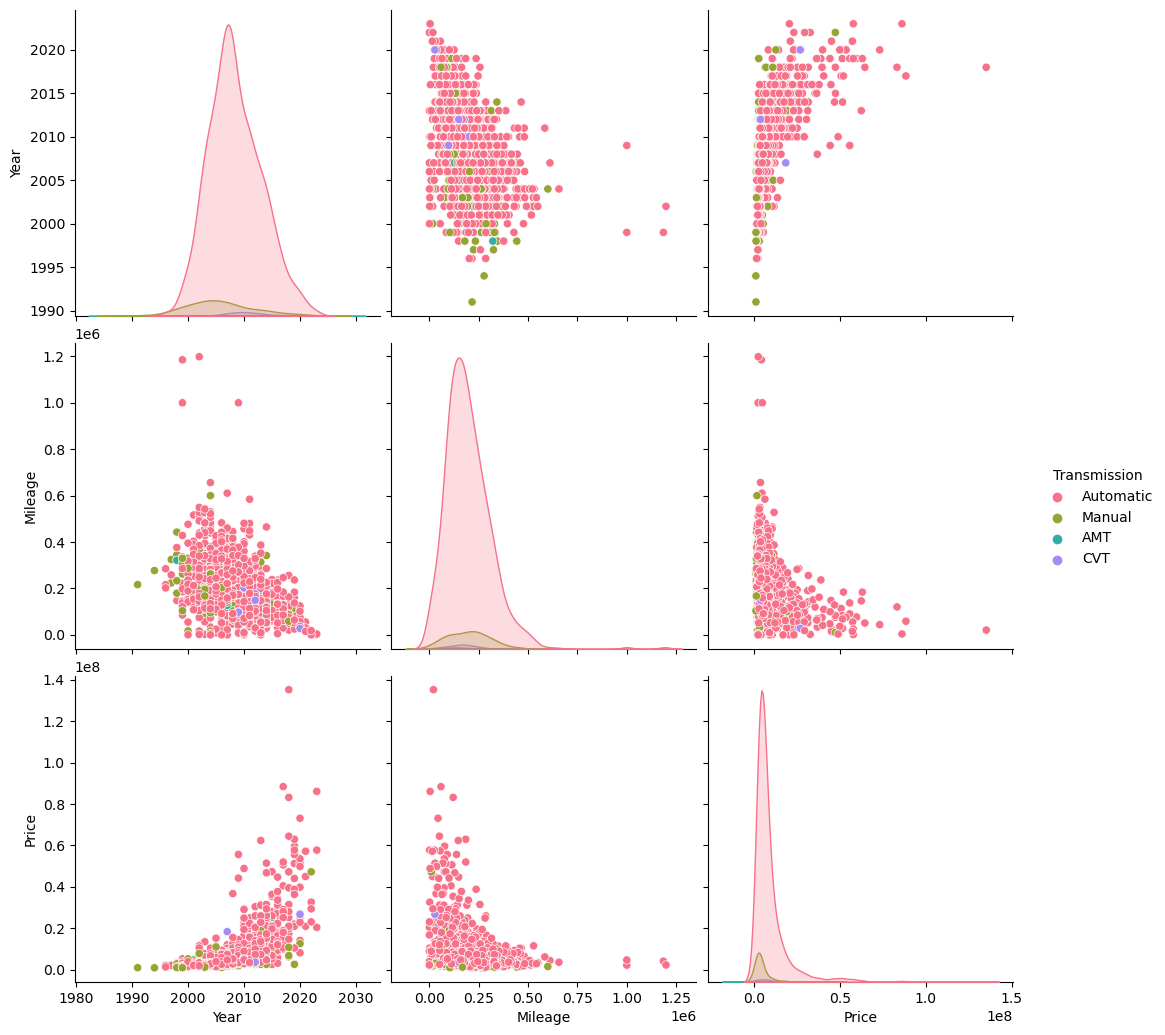

In [48]:
sns.pairplot(newDf,hue = 'Transmission',diag_kind = "kde",kind = "scatter",palette = "husl",height=3.5)
plt.show();


In [49]:
#Average Kilometer driven By Condition

condMileages = newDf.groupby("Condition")["Mileage"].mean().sort_values(ascending=False)
condMileages

Condition
Nigerian Used    202799.067358
Brand New        177919.000000
Foreign Used     172098.946565
Name: Mileage, dtype: float64

In [50]:
newDf.shape

(1421, 5)

In [51]:
newDf.sample(5)

,Transmission,Condition,Year,Mileage,Price
712,Automatic,Nigerian Used,2004,317339,2415000
1346,Automatic,Foreign Used,2010,55625,29120000
995,Automatic,Nigerian Used,2003,481080,2080000
587,Automatic,Nigerian Used,2007,97776,4515000
212,Automatic,Nigerian Used,2017,107837,11856000


In [52]:
newDf.dtypes

Transmission    object
Condition       object
Year             int64
Mileage          int64
Price            int64
dtype: object

In [53]:
# Generating new categorical columns from the dataframe
categ_cols = newDf.select_dtypes(include='O').columns.tolist()
categ_cols

['Transmission', 'Condition']

In [54]:
# One Hot Encoding Using Pandas
newDf = pd.get_dummies(newDf, columns=categ_cols)
newDf.sample(3)

,Year,Mileage,Price,Transmission_AMT,Transmission_Automatic,Transmission_CVT,Transmission_Manual,Condition_Brand New,Condition_Foreign Used,Condition_Nigerian Used
495,2015,88545,14560000,False,True,False,False,False,True,False
773,2006,226168,6300000,False,True,False,False,False,False,True
825,2011,58503,7140000,False,True,False,False,False,False,True


In [55]:
cols_to_replace = ['Transmission_AMT','Transmission_Automatic','Transmission_CVT','Transmission_Manual',
                   'Condition_Brand New','Condition_Foreign Used','Condition_Nigerian Used']

newDf[cols_to_replace] = newDf[cols_to_replace].replace({True: 1, False: 0})

newDf.rename({'Transmission_AMT':'AMT','Transmission_Automatic':'Automatic','Transmission_CVT':'CVT',
             'Transmission_Manual':'Manual','Condition_Brand New':'Brand New',
              'Condition_Foreign Used':'Foreign Used','Condition_Nigerian Used':'Nigerian Used'},axis=1, inplace=True)

In [56]:
newDf.sample(3)

,Year,Mileage,Price,AMT,Automatic,CVT,Manual,Brand New,Foreign Used,Nigerian Used
1405,2002,249341,3360000,0,1,0,0,0,0,1
713,2007,363098,5408000,0,1,0,0,0,0,1
792,2008,107996,4160000,0,1,0,0,0,0,1


Data Segmentation

In [57]:
X = newDf.drop("Price", axis=1)
y = newDf["Price"]

In [59]:
# split data into train and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, shuffle=True)


# Check the shape of the splitted data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1065, 9), (356, 9), (1065,), (356,))

In [60]:
scaler = QuantileTransformer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [62]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred = lr.predict(X_test)

In [64]:
# Evaluate Model
r2_lr = r2_score(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred)

print(f"Linear Regressor - R2 Score: {r2_lr}, MSE: {mse_lr}")


Linear Regressor - R2 Score: 0.44306368472034585, MSE: 50223140567241.03
